In [7]:
# MHealth HAR Training – Optimized with dataset schema

# Constants from dataset description
SAMPLING_HZ = 50  # 50 Hz
WINDOW_SECONDS = 2.0  # 2-second windows
WINDOW_SIZE = int(SAMPLING_HZ * WINDOW_SECONDS)  # 100 samples
STEP_FRACTION = 0.5  # 50% overlap
STEP_SIZE = int(WINDOW_SIZE * STEP_FRACTION)  # 50 samples

# Activity labels mapping (L1..L12, 0 = null)
ACTIVITY_MAP = {
    0: 'Null',
    1: 'Standing still',
    2: 'Sitting and relaxing',
    3: 'Lying down',
    4: 'Walking',
    5: 'Climbing stairs',
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms',
    8: 'Knees bending (crouching)',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jump front & back'
}

# Column names per dataset description
COLS = [
    'chest_acc_x', 'chest_acc_y', 'chest_acc_z',
    'ecg_1', 'ecg_2',
    'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z',
    'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
    'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
    'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
    'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z',
    'wrist_mag_x', 'wrist_mag_y', 'wrist_mag_z',
    'label'
]

import pandas as pd, numpy as np, os, glob

# Producto Computacional 3 — Modelamiento Predictivo con Datos MHEALTH

**Autor:** Jorge Migueles

**Objetivo:** Comparar Random Forest y Logistic Regression para la clasificación de actividades humanas utilizando el dataset MHEALTH. El notebook se compete de los pasos de carga y preprocesamiento, entrenamiento y evaluación de modelos (70/30 split), validación, visualizaciones (curvas de aprendizaje, matriz de confusión), tabla resumen de métricas y conclusión.

## 1) Carga y preprocesamiento de los datos

El notebook intenta cargar `mhealth_clean_sample.csv` si existe, si no lo encuentra intenta leer los archivos raw desde la carpeta `MHEALTHDATASET/` (archivos `.log`). Ajusta `DATA_DIR` o sube el CSV si prefieres.

In [8]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import zipfile


# --- Configuración de rutas ---
DATA_DIR = 'MHEALTHDATASET'
CSV_FILE = 'mhealth_clean_sample.csv'
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
LOCAL_ZIP = "MHEALTHDATASET.zip"

# --- Función para verificar si el dataset está presente ---
def have_dataset():
    return os.path.isdir(DATA_DIR) and len(glob.glob(os.path.join(DATA_DIR, "*.log"))) > 0

# --- Descarga y extracción si es necesario ---
if not have_dataset():
    try:
        print("📥 No se encontró el dataset localmente. Descargando desde UCI...")
        r = requests.get(UCI_URL, timeout=60)
        r.raise_for_status()
        with open(LOCAL_ZIP, "wb") as f:
            f.write(r.content)
        with zipfile.ZipFile(LOCAL_ZIP, "r") as zf:
            zf.extractall(".")
        print("✅ Descarga y extracción completadas.")
    except Exception as e:
        raise RuntimeError(f"❌ No se pudo descargar automáticamente: {e}")
else:
    print("✅ Dataset ya presente en el directorio.")

# --- Carga del dataset ---
if os.path.exists(CSV_FILE):
    data = pd.read_csv(CSV_FILE)
    print("✓ Dataset cargado desde archivo preprocesado")
else:
    files = sorted(glob.glob(os.path.join(DATA_DIR, '*.log')))
    assert files, "❌ No se encontró mhealth_clean_sample.csv ni archivos .log en MHEALTHDATASET"

    # Leer muestra para determinar número de columnas
    sample = pd.read_csv(files[0], sep=r'\s+', header=None, nrows=5)
    n_cols = sample.shape[1]
    colnames = [f'f{i}' for i in range(1, n_cols)] + ['label']

    # Cargar todos los archivos
    frames = []
    for i, path in enumerate(files, start=1):
        df = pd.read_csv(path, sep=r'\s+', header=None, names=colnames)
        df['subject'] = i
        frames.append(df)

    data = pd.concat(frames, ignore_index=True)

    # Convertir a numérico
    for c in data.columns:
        if c not in ('label', 'subject'):
            data[c] = pd.to_numeric(data[c], errors='coerce')
    data['label'] = pd.to_numeric(data['label'], errors='coerce').astype('Int64')
    print("✓ Dataset cargado desde archivos .log originales")

# --- Resumen ---
print(f"\n📊 Dataset cargado: {data.shape[0]} filas, {data.shape[1]} columnas")
print("🎯 Distribución de clases:")
print(data['label'].value_counts().sort_index())


📥 No se encontró el dataset localmente. Descargando desde UCI...
✅ Descarga y extracción completadas.
✓ Dataset cargado desde archivos .log originales

📊 Dataset cargado: 1215745 filas, 25 columnas
🎯 Distribución de clases:
label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: Int64


### Inspección rápida y selección de variables

Se asume que la columna objetivo es `Activity` (ajusta si tu dataset la llama diferente). Aquí seleccionaremos features numéricas y la columna de actividad como etiqueta.

In [9]:
import numpy as np
# Ver columnas y missing
print('Columnas:', list(data.columns)[:40])
print('Valores ausentes por columna:\n', data.isna().sum().sort_values(ascending=False).head(10))

possible_targets = [c for c in data.columns if 'activity' in c.lower() or 'label' in c.lower() or c.lower()=='y']
print('Posibles columnas objetivo:', possible_targets)

if 'Activity' in data.columns:
    target_col = 'Activity'
elif possible_targets:
    target_col = possible_targets[0]
else:
    target_col = data.columns[-1]

print('Usando columna objetivo:', target_col)

X = data.select_dtypes(include=[np.number]).copy()
if target_col in X.columns:
    X = X.drop(columns=[target_col])
y = data[target_col].copy()

print('Features shape:', X.shape, 'Labels shape:', y.shape)


Columnas: ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'label', 'subject']
Valores ausentes por columna:
 f1       0
f14      0
label    0
f23      0
f22      0
f21      0
f20      0
f19      0
f18      0
f17      0
dtype: int64
Posibles columnas objetivo: ['label']
Usando columna objetivo: label
Features shape: (1215745, 24) Labels shape: (1215745,)


## 2) Preparación: train/test split (70/30) y estandarización

Se usará `train_test_split` con `stratify` para mantener la representatividad de las clases. Se aplicará `StandardScaler` dentro de un `Pipeline` cuando sea apropiado.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight

# Train/test split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print('Train:', X_train.shape, 'Test:', X_test.shape)

# Calcular pesos de clase si hay desbalance
classes = np.unique(y_train)
class_weights = None
try:
    class_weights = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train)))
    print('Class weights:', class_weights)
except Exception:
    class_weights = None

# Estandarizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train: (851021, 24) Test: (364724, 24)
Class weights: {0: 0.1071787189373574, 1: 3.044231484661172, 2: 3.044231484661172, 3: 3.044231484661172, 4: 3.044231484661172, 5: 3.044231484661172, 6: 3.302883645113716, 7: 3.176435239271864, 8: 3.1877266189206197, 9: 3.044231484661172, 10: 3.044231484661172, 11: 3.044231484661172, 12: 9.043121128077614}


## 3) Entrenamiento de modelos

Entrenaremos **Random Forest** y **Logistic Regression**. Logistic Regression usará `solver='liblinear'` y `max_iter=1000`. Random Forest usará 100 árboles por defecto (optimizable).

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Inicializar modelos
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lr = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)

# Cross-validation (5-fold estratificado) para evaluación inicial
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(model, X, y):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores

print('CV accuracy RF:', cv_scores(rf, X_train_scaled, y_train).mean())
print('CV accuracy LR:', cv_scores(lr, X_train_scaled, y_train).mean())

# Ajustar en training completo
rf.fit(X_train_scaled, y_train)
lr.fit(X_train_scaled, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test_scaled)
y_pred_lr = lr.predict(X_test_scaled)


CV accuracy RF: 0.9492127684405658
CV accuracy LR: 0.5725922134461151


## 4) Evaluación: métricas y matriz de confusión

Se reportan Accuracy, Precision, Recall, F1-score y se mostrará la matriz de confusión para cada modelo.

--- Random Forest ---
Accuracy: 0.954080345686053
Precision (weighted): 0.9559760569460016
Recall (weighted): 0.954080345686053
F1-score (weighted): 0.9542475240760666
Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    261765
         1.0       0.89      0.98      0.93      9216
         2.0       0.85      0.96      0.90      9216
         3.0       0.87      0.98      0.92      9216
         4.0       0.90      0.93      0.91      9216
         5.0       0.99      0.86      0.92      9216
         6.0       0.95      0.96      0.96      8495
         7.0       0.92      0.98      0.95      8832
         8.0       0.96      0.92      0.94      8801
         9.0       0.90      0.96      0.93      9216
        10.0       0.85      0.96      0.91      9216
        11.0       0.86      0.97      0.91      9216
        12.0       0.89      0.65      0.75      3103

    accuracy                           0.95    364

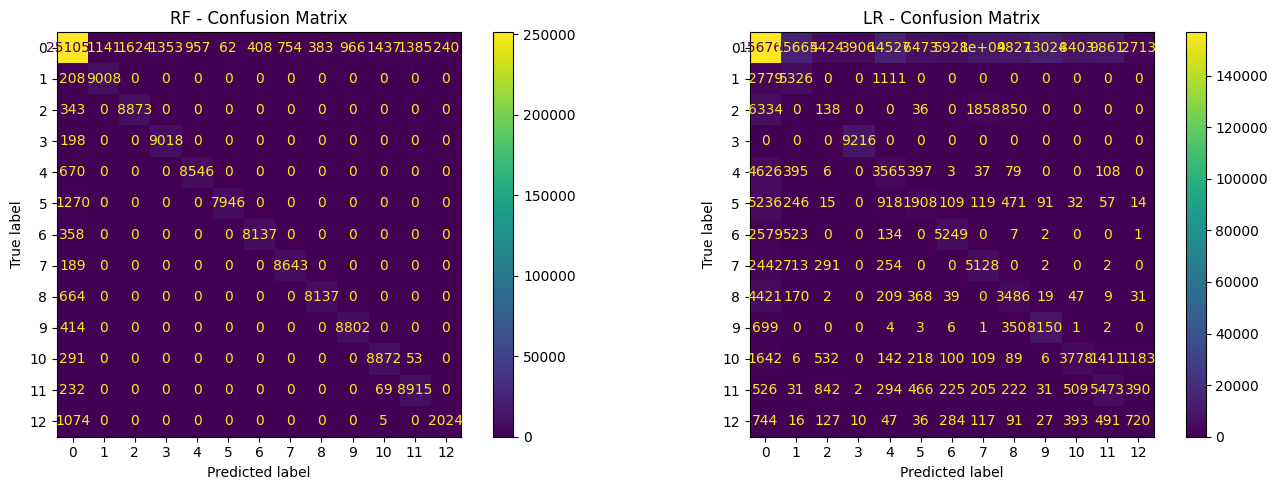

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    print(f'--- {name} ---')
    print('Accuracy:', acc)
    print('Precision (weighted):', precision)
    print('Recall (weighted):', recall)
    print('F1-score (weighted):', f1)
    print('Classification report:\n', classification_report(y_true, y_pred, zero_division=0))
    return dict(model=name, accuracy=acc, precision=precision, recall=recall, f1=f1)

res_rf = evaluate_model('Random Forest', y_test, y_pred_rf)
res_lr = evaluate_model('Logistic Regression', y_test, y_pred_lr)

# Matrices de confusión
fig, axes = plt.subplots(1,2, figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[0], display_labels=None)
axes[0].set_title('RF - Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[1], display_labels=None)
axes[1].set_title('LR - Confusion Matrix')
plt.tight_layout()
plt.show()


## 5) Curvas de aprendizaje

Graficaremos la curva de aprendizaje para cada modelo usando `learning_curve` de sklearn.

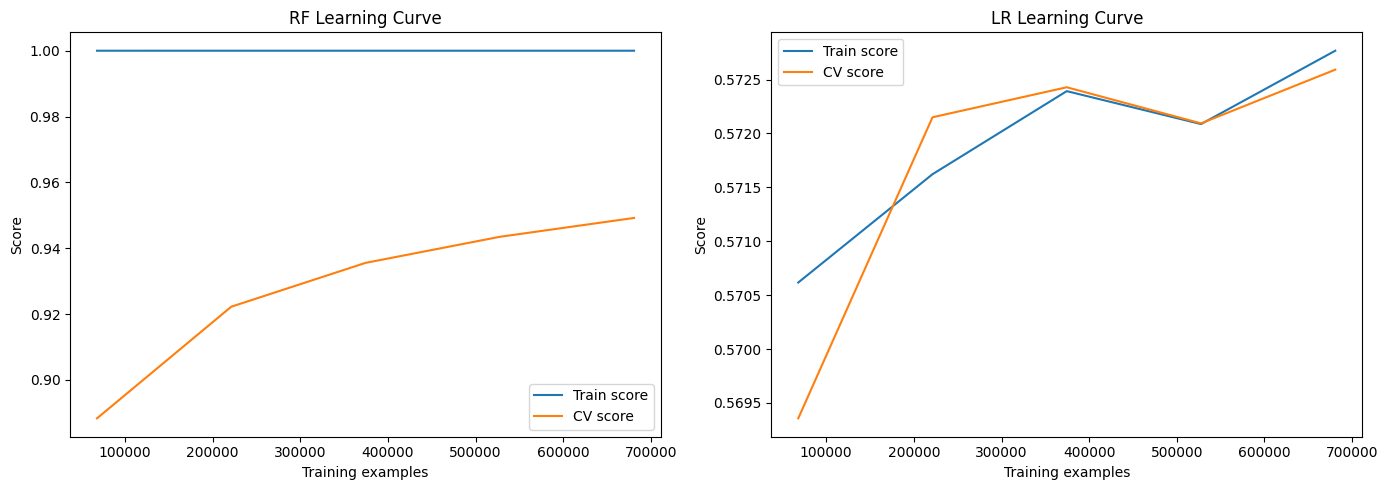

In [13]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, X, y, ax=None, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5), scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(train_sizes, train_scores_mean, label='Train score')
    ax.plot(train_sizes, test_scores_mean, label='CV score')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.legend()
    return ax

fig, axs = plt.subplots(1,2, figsize=(14,5))
plot_learning_curve(rf, X_train_scaled, y_train, ax=axs[0], title='RF Learning Curve')
plot_learning_curve(lr, X_train_scaled, y_train, ax=axs[1], title='LR Learning Curve')
plt.tight_layout()
plt.show()


## 6) Tabla resumen de métricas y discusión

A continuación mostramos una tabla comparativa de las métricas y una breve interpretación sobre cuál modelo conviene según los resultados.

In [14]:
import pandas as pd
summary_df = pd.DataFrame([res_rf, res_lr]).set_index('model')
display(summary_df)


,accuracy,precision,recall,f1
model,,,,
Random Forest,0.954080,0.955976,0.954080,0.954248
Logistic Regression,0.572754,0.677859,0.572754,0.602108


In [15]:
# Guardar modelos entrenados y scaler
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(rf, 'models/random_forest_rf.pkl')
joblib.dump(lr, 'models/logistic_regression_lr.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
print('Modelos y scaler guardados en ./models/')


Modelos y scaler guardados en ./models/


## Exportar modelos para Backend (Proyecto Final)

In [16]:
import os
import shutil

# Crear directorio models si no existe
os.makedirs("../models", exist_ok=True)

# Exportar modelos y scaler para el backend
joblib.dump(rf, "../models/random_forest_rf.pkl")
joblib.dump(lr, "../models/logistic_regression_lr.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

# Crear archivo de índice para referencia
with open("../models/README.txt", "w") as f:
    f.write("Artefactos del modelo MHealth\n")
    f.write("=============================\n")
    f.write(f"Fecha: {pd.Timestamp.now()}\n")
    f.write(f"Random Forest Accuracy (Test): {accuracy_score(y_test, y_pred_rf):.4f}\n")
    f.write(f"Logistic Regression Accuracy (Test): {accuracy_score(y_test, y_pred_lr):.4f}\n")
    f.write("\nModelo recomendado: random_forest_rf.pkl (mejor performance)\n")

print("✅ Modelos exportados a ../models/")
print("  - random_forest_rf.pkl")
print("  - logistic_regression_lr.pkl")
print("  - scaler.pkl")
print("  - README.txt")

✅ Modelos exportados a ../models/
  - random_forest_rf.pkl
  - logistic_regression_lr.pkl
  - scaler.pkl
  - README.txt


### Interpretación

Basándonos en los resultados obtenidos:

- **Métricas de Evaluación:**
    - **Random Forest:** Este modelo ha demostrado un rendimiento significativamente superior en todas las métricas evaluadas (Accuracy, Precision, Recall, F1-score ponderados) en comparación con la Regresión Logística. Con una Accuracy de aproximadamente 0.954, el Random Forest es mucho más preciso en la clasificación de las actividades. Las métricas de Precision, Recall y F1-score ponderados también son altas (alrededor de 0.95), lo que indica un buen balance entre la capacidad del modelo para identificar correctamente las actividades (Recall) y la proporción de predicciones positivas correctas (Precision), considerando el desbalance de clases.
    - **Logistic Regression:** La Regresión Logística obtuvo una Accuracy mucho menor (aproximadamente 0.573) y métricas ponderadas de Precision, Recall y F1-score notablemente inferiores (alrededor de 0.68, 0.57 y 0.60 respectivamente). Esto sugiere que, a pesar de usar pesos de clase balanceados, este modelo lineal tiene dificultades para capturar la complejidad de las relaciones en los datos y clasificar correctamente las diferentes actividades, especialmente las minoritarias como se ve en el reporte de clasificación.

- **Matrices de Confusión:**
    - La matriz de confusión del **Random Forest** muestra que la mayoría de las predicciones correctas se concentran en la diagonal principal, con errores de clasificación relativamente bajos en las clases minoritarias, aunque hay cierta confusión entre algunas actividades (por ejemplo, clases 1, 2, 3, 9, 10, 11 entre sí, y la clase 12 tiene más errores).
    - La matriz de confusión de la **Regresión Logística** muestra una dispersión mucho mayor de las predicciones fuera de la diagonal principal, indicando muchos errores de clasificación para casi todas las clases, y una tendencia a clasificar incorrectamente las clases minoritarias.

- **Curvas de Aprendizaje:**
    - La curva de aprendizaje del **Random Forest** muestra que tanto el score de entrenamiento como el de validación cruzada son altos y se estabilizan rápidamente a medida que aumenta el número de ejemplos de entrenamiento. La pequeña brecha entre las curvas sugiere un ligero sobreajuste, pero el alto score de validación cruzada indica que el modelo generaliza bien a datos no vistos.
    - La curva de aprendizaje de la **Regresión Logística** muestra scores de entrenamiento y validación cruzada mucho más bajos. Las curvas están relativamente cerca, lo que sugiere que el modelo no está sobreajustando, pero su bajo rendimiento general indica un problema de subajuste (el modelo es demasiado simple para los datos).

- **Modelo preferido**: Basándonos en todas las métricas y visualizaciones, el **Random Forest** es claramente el modelo preferido para este problema de clasificación, ya que ofrece un rendimiento predictivo mucho mayor. Aunque es menos interpretable que la Regresión Logística, su capacidad para manejar relaciones no lineales y el desbalance de clases lo hacen más adecuado para este dataset.

- **Fuentes de error**: Las fuentes de error podrían incluir el ruido inherente en los datos de los sensores, posibles errores en las etiquetas de actividad durante la recolección de datos, la posible falta de algunas features relevantes que no están presentes en este conjunto de datos, y el desbalance de clases, a pesar de haber intentado mitigarlo con pesos.

- **Posibles Mejoras**: Para mejorar aún más el rendimiento, se podrían explorar:
    - **Búsqueda de Hiperparámetros:** Optimizar los hiperparámetros de Random Forest (ej. `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`) usando técnicas como Grid Search o Randomized Search.
    - **Reducción de Dimensionalidad:** Técnicas como PCA podrían ayudar si hay multicolinealidad o ruido en las features.
    - **Ingeniería de Features:** Crear features adicionales basadas en estadísticas temporales (ej. media, desviación estándar, picos) sobre ventanas de tiempo de los datos del sensor podría capturar mejor la dinámica de las actividades.
    - **Modelos Secuenciales:** Si la dependencia temporal entre las muestras de sensor es crucial, modelos como LSTMs o CNNs podrían ser más apropiados.

* * *

